In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
from scipy import stats
%matplotlib inline

In [6]:
# 1. Daten Laden
df = pd.read_csv('allData.csv')

# Features auswählen
features = ['t_jup', 'i']
X_original = df[features].dropna()

/var/folders/tv/kwzyy9z51hl6kg2pqz9rjhz00000gn/T/ipykernel_8274/2500729643.py:2: DtypeWarning: Columns (17,23,24,25,36,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('allData.csv')


In [7]:
# 3. Skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# 4. Clustering auf den SKALIERTEN Daten
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10) # k=2 da wir Kometen vs Asteroiden trennen wollen
cluster_labels = kmeans.fit_predict(X_scaled)

X_original['cluster'] = cluster_labels

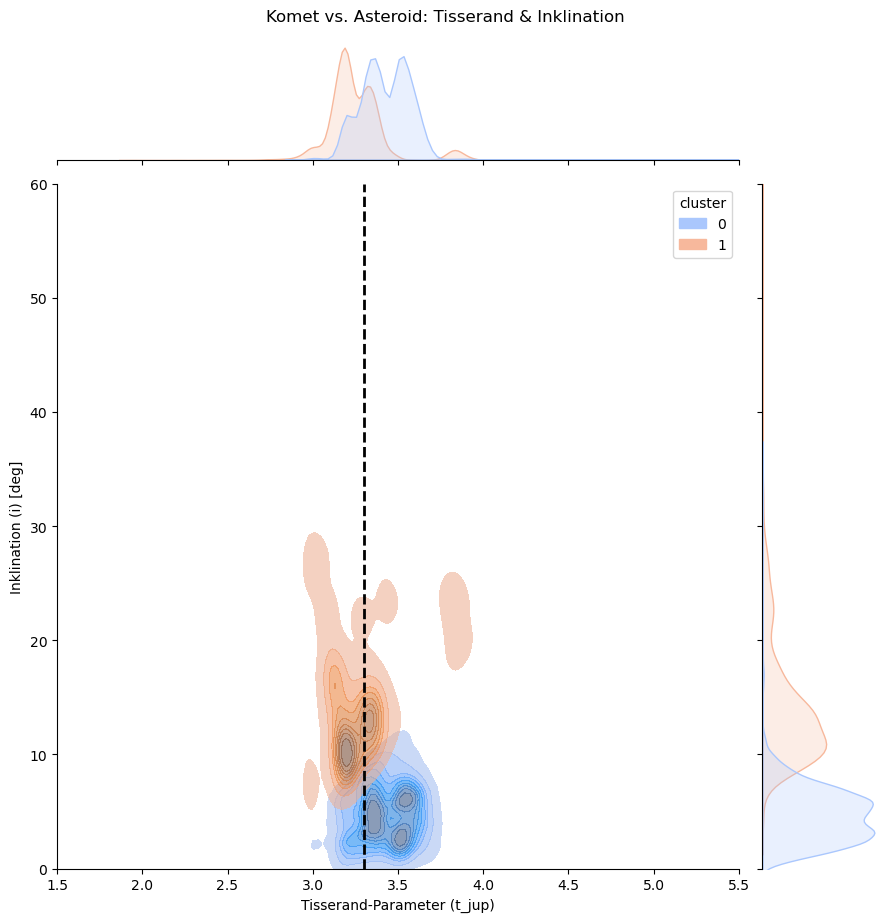

In [9]:
df_plot = X_original.sample(n=20000, random_state=42)

# 2. Der Plot
g = sns.jointplot(
    data=df_plot,
    x='t_jup', 
    y='i', 
    hue='cluster',     # Automatische Einfärbung nach Cluster
    kind='kde',        # 'kde' = Weiche Konturen
    palette='coolwarm', # Gute Farbwahl für Kontraste
    fill=True,         # Flächen füllen
    alpha=0.6,         # Transparenz, damit man Überlappungen sieht
    height=9,          # Größe des Bildes
    xlim=(1.5, 5.5),   # Fokus auf den Übergangsbereich
    ylim=(0, 60)       # Fokus auf Inklination
)

# 3. Achsenbeschriftungen und Titel
g.fig.suptitle('Komet vs. Asteroid: Tisserand & Inklination', y=1.02)
g.set_axis_labels('Tisserand-Parameter (t_jup)', 'Inklination (i) [deg]')

# Die Kometen-Grenze einzeichnen (Senkrechte Linie bei 3.0)
g.ax_joint.axvline(x=3.3, color='black', linestyle='--', linewidth=2, label='Grenze T_J=3.0')

plt.show()

In [8]:
df.loc[X_original.index, 'cluster'] = X_original['cluster']
df.to_csv('clustered_kometVsAsteroid_kmeans.csv', index=False)

Datensatz ist groß (875653). Ziehe Sample von 200.000 Punkten...
Starte DBSCAN Clustering...
Noise (Rauschen): 736 Objekte | Ø T_Jup = 4.62
   -> Verdacht auf Asteroiden
Cluster 0: 199164 Objekte | Ø T_Jup = 3.35
   -> Verdacht auf Asteroiden
Cluster 1: 22 Objekte | Ø T_Jup = 4.26
   -> Verdacht auf Asteroiden
Cluster 2: 58 Objekte | Ø T_Jup = 5.93
   -> Verdacht auf Asteroiden
Cluster 3: 10 Objekte | Ø T_Jup = 4.23
   -> Verdacht auf Asteroiden
Cluster 4: 10 Objekte | Ø T_Jup = 5.77
   -> Verdacht auf Asteroiden
--- Ergebnis ---
Gefundene Cluster: 5
Als Rauschen (Noise) klassifiziert: 736


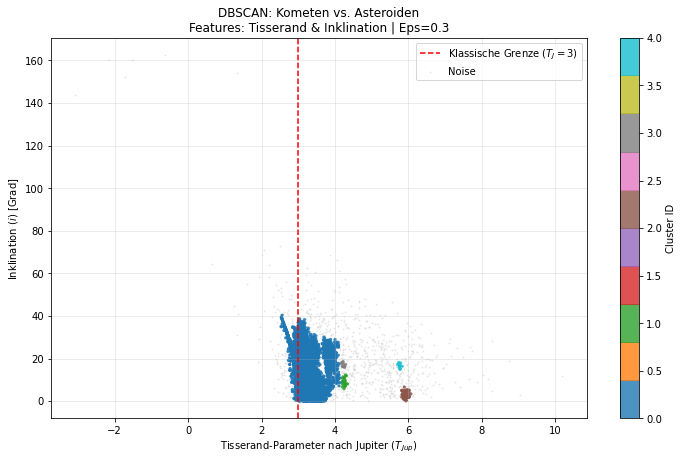

In [ ]:
# Importe (falls noch nicht geladen)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# 1. Daten Vorbereiten
# ---------------------------------------------------------
# Wir nutzen den DataFrame 'df', der im Notebook bereits geladen wurde.
# Falls 'X_original' schon existiert, nutzen wir es, sonst erstellen wir es neu.

features = ['t_jup', 'i']

# Sicherstellen, dass die Daten sauber sind
if 'df' in locals():
    X_original = df[features].dropna()
else:
    # Fallback: Erneut laden, falls die Zelle oben nicht ausgeführt wurde
    try:
        df = pd.read_csv('allData.csv') # Oder der korrekte Pfad zu Ihrer Datei
        X_original = df[features].dropna()
    except:
        print("Bitte führen Sie zuerst die Zelle zum Laden der Daten aus.")

# ---------------------------------------------------------
# 2. Sampling (Wichtig für Performance)
# ---------------------------------------------------------
# Da Asteroiden-Datenbanken riesig sind, ziehen wir für DBSCAN ein Sample.
# 50.000 Punkte reichen für eine visuelle Analyse völlig aus.
if len(X_original) > 200000:
    print(f"Datensatz ist groß ({len(X_original)}). Ziehe Sample von 200.000 Punkten...")
    X_sample = X_original.sample(n=200000, random_state=42).copy()
else:
    X_sample = X_original.copy()

# ---------------------------------------------------------
# 3. Skalieren (Essentiell!)
# ---------------------------------------------------------
# t_jup liegt meist zwischen 2 und 4, i zwischen 0 und 180. 
# Ohne Skalierung würde die Inklination das Clustering dominieren.
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# ---------------------------------------------------------
# 4. DBSCAN Algorithmus
# ---------------------------------------------------------
print("Starte DBSCAN Clustering...")

# eps=0.3: Radius der Nachbarschaft (in Standardabweichungen)
# min_samples=10: Mindestanzahl Objekte pro Cluster
# n_jobs=-1: Nutzt alle CPU-Kerne für Geschwindigkeit
dbscan = DBSCAN(eps=0.3, min_samples=10, n_jobs=-1)
labels = dbscan.fit_predict(X_sample_scaled)

# Ergebnisse speichern
X_sample['cluster'] = labels

# Analyse der Cluster-Inhalte
for label in sorted(X_sample['cluster'].unique()):
    subset = X_sample[X_sample['cluster'] == label]
    
    # Name der Gruppe
    group_name = f"Cluster {label}" if label != -1 else "Noise (Rauschen)"
    
    # Durchschnittlicher Tisserand-Parameter
    avg_tj = subset['t_jup'].mean()
    count = len(subset)
    
    print(f"{group_name}: {count} Objekte | Ø T_Jup = {avg_tj:.2f}")

    # Interpretation
    if avg_tj < 3.0:
        print("   -> Verdacht auf Kometen-ähnliche Bahnen")
    else:
        print("   -> Verdacht auf Asteroiden")

# ---------------------------------------------------------
# 5. Visualisierung & Statistik
# ---------------------------------------------------------
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"--- Ergebnis ---")
print(f"Gefundene Cluster: {n_clusters}")
print(f"Als Rauschen (Noise) klassifiziert: {n_noise}")

plt.figure(figsize=(12, 7))

# 1. Rauschen plotten (grau, transparent)
# Das sind oft Objekte, die weder klar Asteroid noch klassischer Komet sind
noise_data = X_sample[X_sample['cluster'] == -1]
plt.scatter(noise_data['t_jup'], noise_data['i'], 
            c='lightgray', s=1, alpha=0.4, label='Noise')

# 2. Cluster plotten (bunt)
cluster_data = X_sample[X_sample['cluster'] != -1]
scatter = plt.scatter(cluster_data['t_jup'], cluster_data['i'], 
                      c=cluster_data['cluster'], 
                      cmap='tab10', s=5, alpha=0.8)

# Rote Linie bei T_J = 3 (Die klassische Grenze)
# T_J > 3: Meist Asteroiden | 2 < T_J < 3: Jupiter-Familie Kometen
plt.axvline(x=3.3, color='red', linestyle='--', linewidth=1.5, label='Klassische Grenze ($T_J=3$)')

plt.title(f'DBSCAN: Kometen vs. Asteroiden\nFeatures: Tisserand & Inklination | Eps=0.3')
plt.xlabel('Tisserand-Parameter nach Jupiter ($T_{Jup}$)')
plt.ylabel('Inklination ($i$) [Grad]')
plt.colorbar(scatter, label='Cluster ID')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# X-Achse umdrehen ist bei Tisserand üblich, da Kometen links (<3) liegen
# plt.gca().invert_xaxis() 

plt.show()

In [ ]:
import os

# ---------------------------------------------------------
# 1. Automatische Interpretation der Cluster
# ---------------------------------------------------------
print("\n--- Automatische Analyse der Gruppen ---")

# Wir prüfen jeden Cluster (und das Rauschen)
for label in sorted(X_sample['cluster'].unique()):
    subset = X_sample[X_sample['cluster'] == label]
    
    # Berechne durchschnittlichen Tisserand-Parameter
    avg_tj = subset['t_jup'].mean()
    count = len(subset)
    
    # Bezeichnung
    if label == -1:
        name = "Rauschen (Noise)"
    else:
        name = f"Cluster {label}"
    
    # Einfache Heuristik für die Ausgabe
    # T_J < 3 ist das klassische Kriterium für Kometen der Jupiter-Familie
    obj_type = "KOMETEN-Kandidaten (T_J < 3)" if avg_tj < 3.0 else "ASTEROIDEN (T_J >= 3)"
    
    print(f"{name:20} : {count:5d} Objekte | Ø T_Jup = {avg_tj:.2f} -> {obj_type}")

# ---------------------------------------------------------
# 2. Export als CSV
# ---------------------------------------------------------
# Ordner 'clustering' sicherstellen, falls er nicht existiert

# Dateiname
output_file = os.path.join('komet_vs_asteroid_clusters_dbscan.csv')

# Speichern (ohne den Pandas-Index)
X_sample.to_csv(output_file, index=False)

print(f"\n✅ Export erfolgreich! Datei gespeichert unter: '{output_file}'")